# Importing the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Using TensorFlow backend.


In [2]:
import tensorflow as tf
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                # Convert the image from BGR to RGB
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



# Data Visualization & Preprocessing

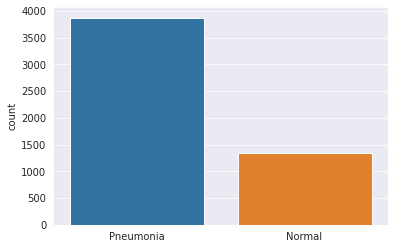

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

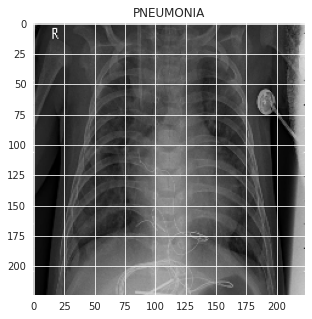

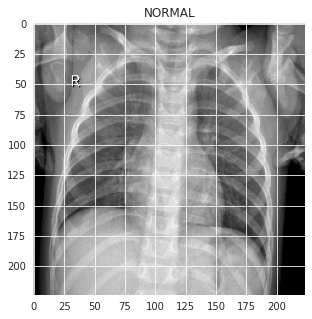

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# Normalize the data
# x_train = np.array(x_train) / 255
# x_val = np.array(x_val) / 255
# x_test = np.array(x_test) / 255
train_img = np.array(x_train) / 255
train_label=np.array(y_train)
test_img = np.array(x_test) / 255
test_label=np.array(y_test)
val_img = np.array(x_val) / 255
val_label=np.array(y_val)


In [8]:
# x_train.shape

In [9]:
# from imblearn.over_sampling import SMOTE
# #Flattening the image array into 2D (making it [2940 images] x [all the pixels of the image in just one 1D array]) to be suitable for SMOTE oversampling
# x_train = x_train.reshape(5216, (img_size*img_size*3))

# #Performing oversampling
# smote = SMOTE(random_state=42)
# x_train, y_train = smote.fit_resample(x_train, y_train)

# #Unflattening the images now to use them for convolutional neural network (4914 images of 256x256 size, with 1 color channel (grayscale, as compared to RGB with 3 color channels))
# x_train = x_train.reshape(-1, img_size, img_size, 3)
# print(x_train.shape)

In [10]:
#Classes balanced - equal counts of each label
# print(np.unique(y_train, return_counts=True))

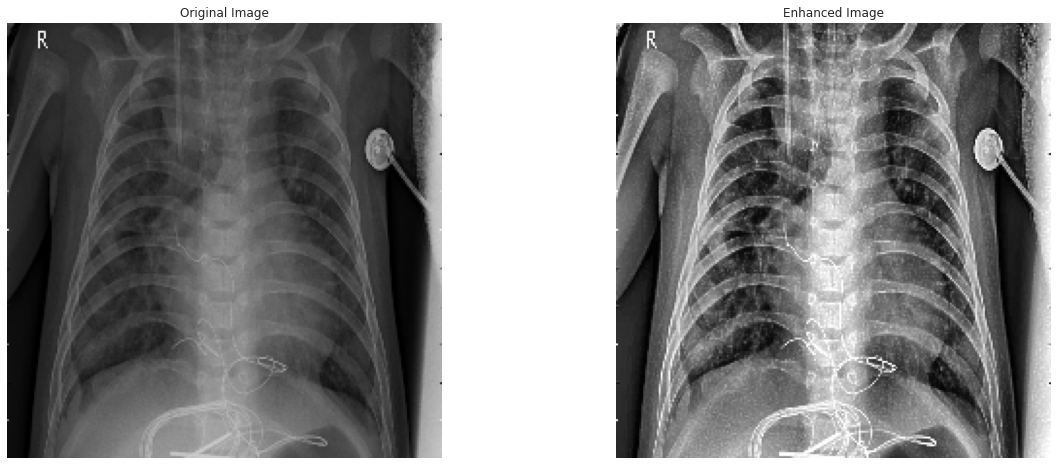

In [11]:
train2 = []  # This will store the enhanced images and their labels
for idx, image in enumerate(train_img):
    label = y_train[idx]  # Extract the corresponding label
    
    # Split the image into its R, G, and B channels
    b, g, r = cv2.split(image)

    # Convert each channel to 8-bit unsigned integer format if necessary
    b = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    r = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)

    # Merge the channels back into a single RGB image
    enhanced_image = cv2.merge([b, g, r])

    # Create a high-pass filter by subtracting a low-pass filter from the original
    low_pass = cv2.boxFilter(enhanced_image, ddepth=-1, ksize=(3, 3))
    high_pass = cv2.subtract(enhanced_image, low_pass)

    # Combine the high-pass filter with the original image to enhance edges
    enhanced_image = cv2.add(enhanced_image, high_pass)

    # Apply Canny edge detection
    feature = cv2.Canny(enhanced_image, 250, 300, apertureSize=3)
    
    # Apply morphological operations to remove noise
    kernel = np.ones((3, 3), np.uint8)
    feature_cleaned = cv2.morphologyEx(feature, cv2.MORPH_OPEN, kernel)
    
    # Convert the single-channel Canny result to 3 channels
    feature_rgb = cv2.cvtColor(feature_cleaned, cv2.COLOR_GRAY2BGR)

    # Add the Canny edges back to the enhanced RGB image
    final_output = cv2.add(enhanced_image, feature_rgb)

    # Save the final enhanced image with its label in train2
    train2.append([final_output, label])

# Example: Display an original and enhanced image side by side
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
if len(train[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(train[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(train[0][0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
if len(train2[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(train2[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(train2[0][0], cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.show()


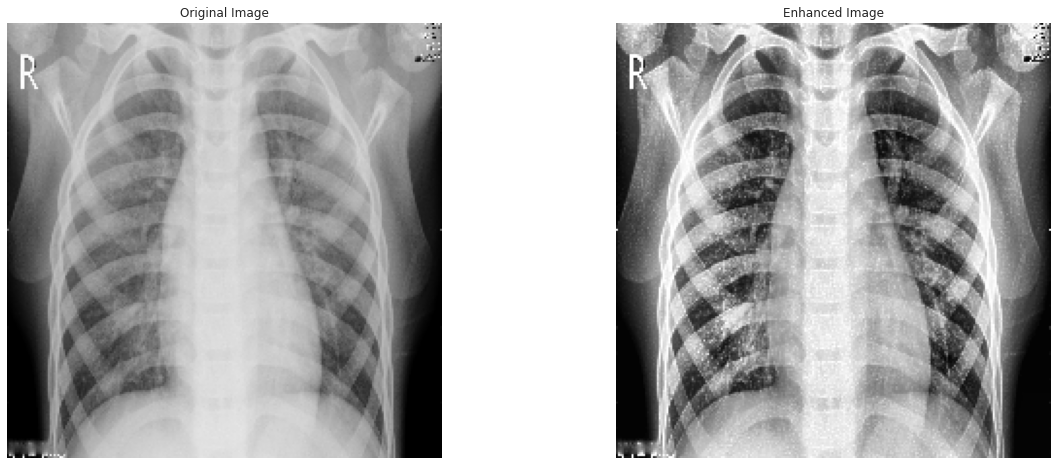

In [12]:
test2 = []  # This will store the enhanced images and their labels
for idx, image in enumerate(test_img):
    label = y_test[idx]  # Extract the corresponding label
    
    # Split the image into its R, G, and B channels
    b, g, r = cv2.split(image)

    # Convert each channel to 8-bit unsigned integer format if necessary
    b = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    r = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)

    # Merge the channels back into a single RGB image
    enhanced_image = cv2.merge([b, g, r])

    # Create a high-pass filter by subtracting a low-pass filter from the original
    low_pass = cv2.boxFilter(enhanced_image, ddepth=-1, ksize=(3, 3))
    high_pass = cv2.subtract(enhanced_image, low_pass)

    # Combine the high-pass filter with the original image to enhance edges
    enhanced_image = cv2.add(enhanced_image, high_pass)

    # Apply Canny edge detection
    feature = cv2.Canny(enhanced_image, 250, 300, apertureSize=3)
    
    # Apply morphological operations to remove noise
    kernel = np.ones((3, 3), np.uint8)
    feature_cleaned = cv2.morphologyEx(feature, cv2.MORPH_OPEN, kernel)
    
    # Convert the single-channel Canny result to 3 channels
    feature_rgb = cv2.cvtColor(feature_cleaned, cv2.COLOR_GRAY2BGR)

    # Add the Canny edges back to the enhanced RGB image
    final_output = cv2.add(enhanced_image, feature_rgb)

    # Save the final enhanced image with its label in train2
    test2.append([final_output, label])

# Example: Display an original and enhanced image side by side
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
if len(test[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(test[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(test[0][0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
if len(test2[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(test2[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(test2[0][0], cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.show()


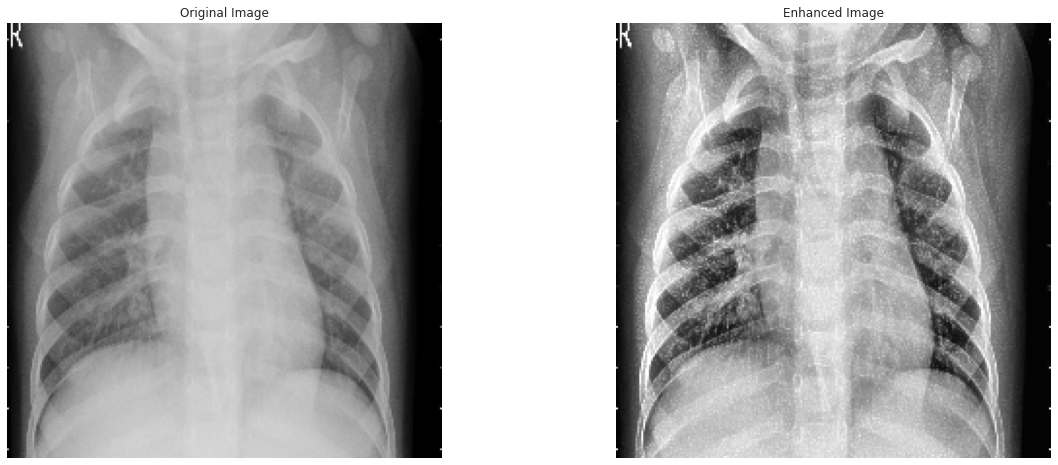

In [13]:
val2 = []  # This will store the enhanced images and their labels
for idx, image in enumerate(val_img):
    label = y_val[idx]  # Extract the corresponding label
    
    # Split the image into its R, G, and B channels
    b, g, r = cv2.split(image)

    # Convert each channel to 8-bit unsigned integer format if necessary
    b = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    r = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)

    # Merge the channels back into a single RGB image
    enhanced_image = cv2.merge([b, g, r])

    # Create a high-pass filter by subtracting a low-pass filter from the original
    low_pass = cv2.boxFilter(enhanced_image, ddepth=-1, ksize=(3, 3))
    high_pass = cv2.subtract(enhanced_image, low_pass)

    # Combine the high-pass filter with the original image to enhance edges
    enhanced_image = cv2.add(enhanced_image, high_pass)

    # Apply Canny edge detection
    feature = cv2.Canny(enhanced_image, 250, 300, apertureSize=3)
    
    # Apply morphological operations to remove noise
    kernel = np.ones((3, 3), np.uint8)
    feature_cleaned = cv2.morphologyEx(feature, cv2.MORPH_OPEN, kernel)
    
    # Convert the single-channel Canny result to 3 channels
    feature_rgb = cv2.cvtColor(feature_cleaned, cv2.COLOR_GRAY2BGR)

    # Add the Canny edges back to the enhanced RGB image
    final_output = cv2.add(enhanced_image, feature_rgb)

    # Save the final enhanced image with its label in train2
    val2.append([final_output, label])

# Example: Display an original and enhanced image side by side
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
if len(val[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(val[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(train[0][0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
if len(val2[0][0].shape) == 3:
    plt.imshow(cv2.cvtColor(val2[0][0], cv2.COLOR_BGR2RGB))
else:
    plt.imshow(val2[0][0], cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.show()


In [14]:
train_img=[]
i=1
for idx, image in enumerate(x_train):
    label = y_train[idx]  # Extract the label
    
    train_img.append([image, label])
enhanced_train_img=train2

train_img.extend(enhanced_train_img)

In [15]:
test_img=[]
i=1
for idx, image in enumerate(x_test):
    label = y_test[idx]  # Extract the label
    
    test_img.append([image, label])
enhanced_test_img=test2
test_img.extend(enhanced_test_img)

In [16]:
len(train_img)

10432

In [17]:
len(test_img)

1248

In [18]:
val_img=[]
i=1
for idx, image in enumerate(x_val):
    label = y_val[idx]  # Extract the label
    
    val_img.append([image, label])
enhanced_val_img=val2

val_img.extend(enhanced_val_img)

In [19]:
len(val_img)

32

In [20]:
image_train = []
label_train = []

image_val = []
label_val = []

image_test = []
label_test = []

for feature, label in train_img:
    image_train.append(feature)
    label_train.append(label)

for feature, label in test_img:
    image_test.append(feature)
    label_test.append(label)
    
for feature, label in val_img:
    image_val.append(feature)
    label_val.append(label)

In [21]:
import numpy as np
image_train=np.array(image_train)
label_train=np.array(label_train)
image_test=np.array(image_test)
label_test=np.array(label_test)
image_val=np.array(image_val)
label_val=np.array(label_val)

In [22]:
# resize data for deep learning
img_size=224
image_train = image_train.reshape(-1, img_size, img_size, 3)
image_val = image_val.reshape(-1, img_size, img_size, 3)
image_test = image_test.reshape(-1, img_size, img_size, 3)


In [23]:
# img_size=224
# train_img = train_img.reshape(-1, img_size, img_size, 3)
# val_img = val_img.reshape(-1, img_size, img_size, 3)
# test_img = test_img.reshape(-1, img_size, img_size, 3)


In [24]:
image_train.shape

(10432, 224, 224, 3)

In [25]:
#Importing the necessary libraries
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [26]:
# Load VGG16 model without the top layer
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

58892288/58889256 [==============================] - 0s 0us/step


In [27]:
# # Set trainable layers
conv_base.trainable = False
# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True


In [28]:
# Create the Sequential model and add the conv_base and FC layers
model = Sequential()
model.add(conv_base)
model.add(Flatten())

# Adding fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding another dropout layer
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [30]:
#Compiling the model with parameters best suited for the task at hand:
model.compile(
    loss='binary_crossentropy', #Best for binary classification
    optimizer = keras.optimizers.Adam(learning_rate=0.001), #Good starting LR for dataset of this size
    metrics=['accuracy'], #Looking for accuracy
)

In [31]:
#Fitting the model, with the ReduceLROnPlateau callback added to it to reduce the learning rate to take smaller steps in increasing the accuracy whenever the learning rate plateaus (goes in the wrong direction)
#Doing this with patience=1, meaning it will perform this if it even plateaus for one epoch, since only 10 epochs are used
#factor=0.1 means that for every time the learning rate is reduced, it is reduced by a factor of 0.1 - it also won't go lower than 0.00001
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

#Fitting the model w/ the callback. ON VS CODE, batch size of 16 makes each epoch take around a minute in this case w/ good accuracy, making the whole training process 10 min, but on Kaggle it should take longer due to less computational resources:
history = model.fit(image_train, label_train, batch_size=32, epochs=15, verbose=2, callbacks = [reduce_lr],validation_data=[image_val,label_val])

Train on 10432 samples, validate on 32 samples
Epoch 1/15
 - 54s - loss: 1.5089 - accuracy: 0.8561 - val_loss: 0.4107 - val_accuracy: 0.8125
Epoch 2/15
 - 52s - loss: 0.3605 - accuracy: 0.8654 - val_loss: 0.4254 - val_accuracy: 0.8438
Epoch 3/15
 - 53s - loss: 0.3373 - accuracy: 0.8320 - val_loss: 0.4251 - val_accuracy: 0.8438

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/15
 - 53s - loss: 0.2873 - accuracy: 0.8174 - val_loss: 0.2769 - val_accuracy: 0.9062

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/15
 - 53s - loss: 0.2365 - accuracy: 0.8595 - val_loss: 0.3404 - val_accuracy: 0.8750

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 6/15
 - 53s - loss: 0.2303 - accuracy: 0.8649 - val_loss: 0.3288 - val_accuracy: 0.8750
Epoch 7/15
 - 53s - loss: 0.2232 - accuracy: 0.8683 - val_loss: 0.2647 - val_accuracy: 0.8750
Epoch 8/15
 - 53s - loss: 0.2176 - accuracy: 0.8746 - val_loss: 0.

In [32]:
# print("Loss of the model is - " , model.evaluate(test_img,test_label)[0])
# print("Accuracy of the model is - " , model.evaluate(test_img,test_label)[1]*100 , "%")

In [33]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

1248/1248 [==============================] - 6s 5ms/step
Loss of the model is -  3.5567398433695794
1248/1248 [==============================] - 6s 5ms/step
Accuracy of the model is -  84.69551205635071 %


**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

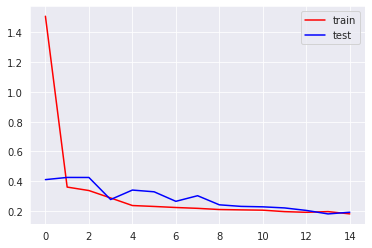

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

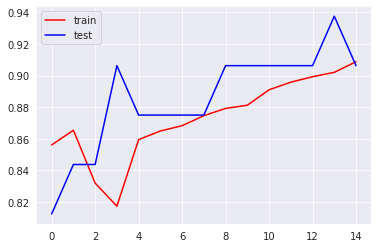

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

In [37]:
predictions = model.predict_classes(image_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [38]:
predictions = model.predict_classes(image_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [40]:
print(classification_report(label_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.82      0.98      0.89       780
   Normal (Class 1)       0.94      0.63      0.76       468

           accuracy                           0.85      1248
          macro avg       0.88      0.80      0.82      1248
       weighted avg       0.86      0.85      0.84      1248



In [ ]:
print(classification_report(label_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(test_label,predictions)
cm

In [41]:
cm = confusion_matrix(label_test,predictions)
cm

array([[761,  19],
       [172, 296]])